In [276]:
!pip install img2vec_pytorch
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [277]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from img2vec_pytorch import Img2Vec

In [278]:
img = cv2.imread('/content/drive/My Drive/test_119.jpg')
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=1/255.0,
                             size=(416,416),
                             swapRB=True)

In [279]:
net = cv2.dnn.readNetFromDarknet('/content/drive/My Drive/retail_detect/yolov3.cfg',
                                 '/content/drive/My Drive/retail_detect/30.weights')
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
img2vec = Img2Vec(cuda=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [280]:
type(net)
net.getUnconnectedOutLayersNames()
net.setInput(blob)
result = net.forward(net.getUnconnectedOutLayersNames())

In [281]:
boxes = []
confidences = []
classIDs = []
W = img.shape[1]
H = img.shape[0]

In [282]:
for output in result:
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    if confidence > 0.8:
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)

In [283]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.9)

In [284]:
with open('/content/drive/My Drive/retail_detect/coco.names', 'r') as labels_file:
  LABELS = labels_file.read().split()

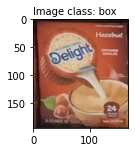

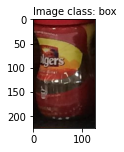

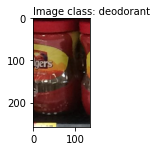

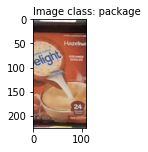

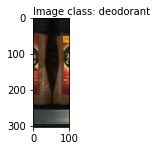

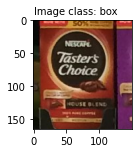

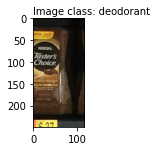

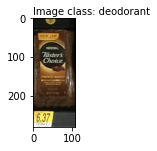

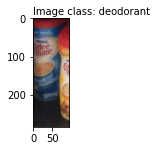

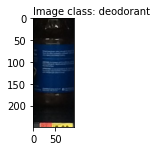

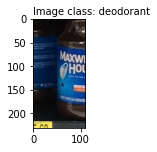

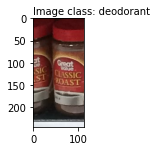

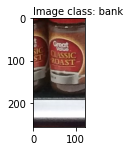

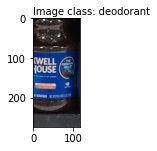

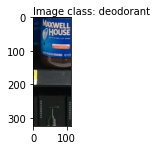

In [285]:
crop_images = []
image = img.copy()
if len(idxs) > 0:
  for i in idxs.flatten():
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    if w > 5 and h > 5:
      crop_image = img[y:y+h, x:x+w]
      tup = (i, crop_image)
      crop_images.append(tup)
      plt.figure(figsize=(3,2))
      plt.text(0, -9, 'Image class: {}'.format(LABELS[classIDs[i]]))
      plt.imshow(crop_image[:,:,::-1])
    color = [0, 255, 0]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 5)
    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

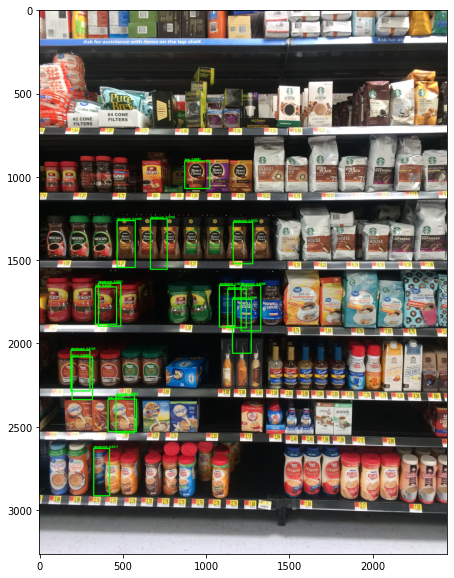

In [286]:
plt.figure(figsize=(15,10))
plt.imshow(image[:,:,::-1])
for crop in crop_images:
  #p = crop_images.index(crop)
  cv2.imwrite('/content/drive/My Drive/retail_detect/crop/' + str(crop[0]) + '.jpg', crop[1])

In [287]:
references = []
for label in LABELS:
  for i in range(1, 20):
    s = "/content/drive/My Drive/retail_detect/mydata/{}/{}_{}.jpg".format(label,
                                                                           label,
                                                                           i)
    vec = img2vec.get_vec(Image.open(s), tensor=True)
    tup = (vec, label)
    references.append(tup)

In [288]:
crop_vectors = []
for i in range(len(crop_images)):
  vec = img2vec.get_vec(Image.open('/content/drive/My Drive/retail_detect/crop/' + str(p) + '.jpg'), tensor = True)
  tup = (i, vec)
  crop_vectors.append(tup)
 # print(tup[0])

In [289]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [290]:
ind_labels = []
cos_sims = []
max_sim = 0
for crop in crop_vectors:
  for i in references:
    cos_sim = cos(crop[1].reshape((1, -1)),
                  i[0].reshape((1, -1)))
    #print(cos_sim, i[1])
    if max_sim < cos_sim:
      max_sim = cos_sim
      ind_label = i[1]
     # print(i[1])
  ind_labels.append(ind_label)
  cos_sims.append(max_sim)
  #print(max_sim)
  max_sim = 0
  #print(max_sim)
  #print(crop_vectors.index(crop))
#print(ind_labels)

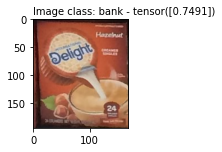

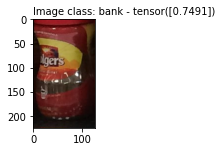

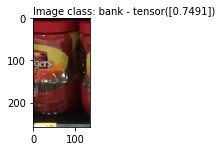

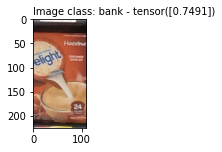

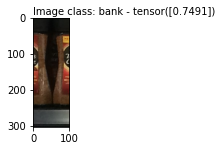

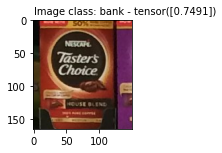

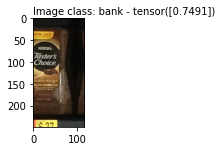

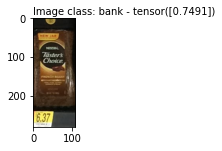

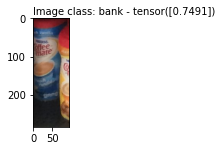

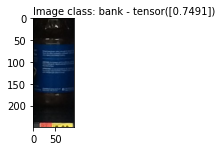

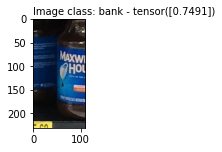

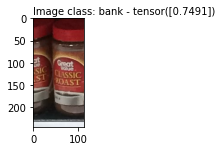

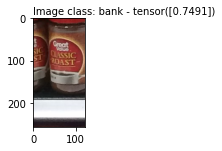

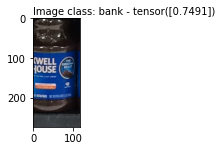

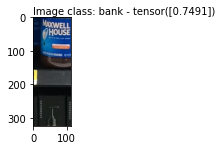

In [291]:
for i in crop_images:
  plt.figure(figsize=(3,2))
  plt.text(0, -9, 'Image class: {} - {}'.format(ind_labels[i[0]],
                                                cos_sims[i[0]]))
  plt.imshow(i[1][:,:,::-1])
  